# ML-Based DeFi Credit Scoring Model – ZIP-Compatible Version
This notebook extracts wallet transaction data from a ZIP file, processes it, and builds a Random Forest model to generate DeFi credit scores.

In [ ]:
import json
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

## 1. Extract JSON from ZIP

In [12]:
with open('user-wallet-transactions.json','r') as f:
  data = json.load(f)

df=pd.DataFrame(data)

df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


## 2. Load and preprocess data

In [13]:


df = pd.DataFrame(data)
df['wallet'] = df['userWallet']
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['action'] = df['action'].str.lower()
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) / 1e6)

## 3. Aggregate Features

In [14]:
agg = df.groupby('wallet').agg(
    txn_count=('action', 'count'),
    total_amount=('amount', 'sum'),
    avg_amount=('amount', 'mean'),
    amount_std=('amount', 'std'),
    max_amount=('amount', 'max'),
    unique_actions=('action', pd.Series.nunique)
)

action_counts = df.pivot_table(index='wallet', columns='action', aggfunc='size', fill_value=0)
for col in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
    if col not in action_counts.columns:
        action_counts[col] = 0

features = pd.concat([agg, action_counts], axis=1).fillna(0)
features['repay_ratio'] = np.where(features['borrow'] > 0, features['repay'] / features['borrow'], 1.0)
features['deposit_ratio'] = np.where(features['txn_count'] > 0, features['deposit'] / features['txn_count'], 0)

## 4. Create Target Labels

In [15]:
def create_target_labels(features):
    target = np.full(len(features), 500.0)
    target += features['deposit'] * 20
    target += features['repay'] * 25
    target += features['repay_ratio'] * 100
    target += features['unique_actions'] * 15
    target += np.log1p(features['txn_count']) * 30
    target -= features['liquidationcall'] * 150
    target -= np.maximum(0, features['borrow'] - features['repay']) * 20
    volatility_penalty = np.where(
        features['amount_std'] > features['avg_amount'] * 2,
        -100,
        0
    )
    target += volatility_penalty
    np.random.seed(42)
    noise = np.random.normal(0, 20, len(target))
    target += noise
    return np.clip(target, 0, 1000)

y = create_target_labels(features)

## 5. Prepare Features for ML

In [16]:
X = features.drop(columns=['txn_count'])
X = X.replace([np.inf, -np.inf], 0).fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 6. Train Random Forest Model

In [17]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

credit_scores = model.predict(X_scaled)
credit_scores = np.clip(credit_scores, 0, 1000).astype(int)

output = pd.DataFrame({
    'wallet': features.index,
    'credit_score': credit_scores
})

## 7. Evaluate Model and Feature Importance

In [18]:
print("Model Performance:")
print(f"Training R²: {model.score(X_train, y_train):.3f}")
print(f"Testing R²: {model.score(X_test, y_test):.3f}")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance.head())

print("\nCredit Score Distribution:")
print(f"Mean: {output['credit_score'].mean():.1f}")
print(f"Min: {output['credit_score'].min()}")
print(f"Max: {output['credit_score'].max()}")
print(f"Std: {output['credit_score'].std():.1f}")

Model Performance:
Training R²: 0.970
Testing R²: 0.937

Top 5 Important Features:
            feature  importance
9             repay    0.590924
6           deposit    0.152821
7   liquidationcall    0.116788
10      repay_ratio    0.061562
11    deposit_ratio    0.022957

Credit Score Distribution:
Mean: 740.5
Min: 39
Max: 1000
Std: 144.0


## 8. Plot Score Distribution and Feature Importance

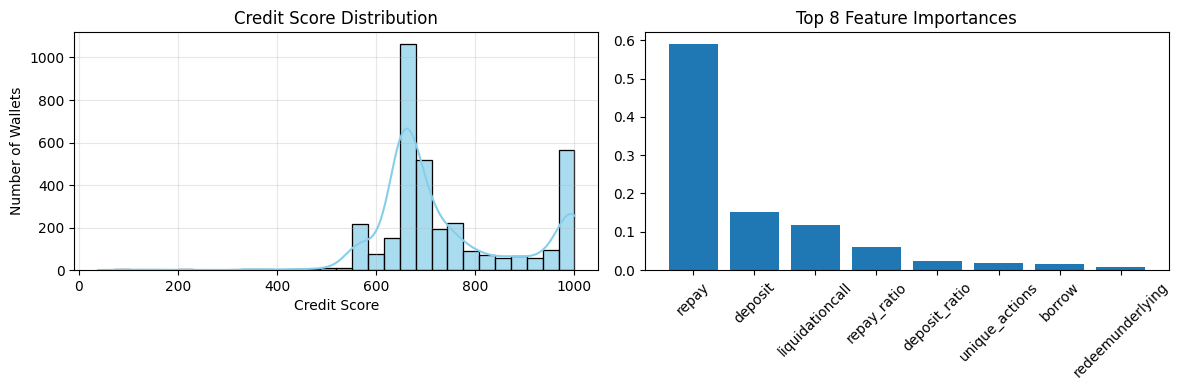

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(output['credit_score'], bins=30, alpha=0.7, color='skyblue', kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(feature_importance.head(8)['feature'], feature_importance.head(8)['importance'])
plt.title('Top 8 Feature Importances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()